# Q2.5: Titanic Autoencoder (Sparse vs Denoising)

Compare a **Sparse Autoencoder (L1 activity regularizer)** vs a **Denoising Autoencoder (GaussianNoise)** on Titanic-style tabular data.

**Exam outputs:** loss curves and reconstruction comparison for both variants.

## Step 1: Import Libraries

In [1]:
# Install tensorflow if not already installed (this line should be executed first)
try:
    import tensorflow
except ImportError:
    print("TensorFlow not found. Installing now...")
    !pip install tensorflow
    print("TensorFlow installed. Please restart the runtime to ensure all imports work correctly.")

TensorFlow not found. Installing now...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 818.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 140.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 127.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.3 MB/s eta 0:00:00
TensorFlow installed. Please restart the runtime to ensure all imports work correctly.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GaussianNoise
from tensorflow.keras import regularizers

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


## Step 2: Load Titanic Dataset

### Load from URL

In [3]:
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)
print(f"Dataset Shape: {df.shape}")
print(f"\nFirst 5 rows:\n{df.head()}")

Dataset Shape: (891, 12)

First 5 rows:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0       

### Preprocess Data

In [4]:
# Select relevant features
df = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].copy()

# Fill missing values
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Encode categorical variables
le_sex = LabelEncoder()
le_emb = LabelEncoder()
df['Sex'] = le_sex.fit_transform(df['Sex'])
df['Embarked'] = le_emb.fit_transform(df['Embarked'])

X = df.values
print(f"\nProcessed Data Shape: {X.shape}")


Processed Data Shape: (891, 7)


/tmp/ipython-input-3266123396.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/tmp/ipython-input-3266123396.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

### Normalize Features

In [5]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)
print(f"Normalized Data Shape: {X_norm.shape}")

Normalized Data Shape: (891, 7)


## Step 3: Build Sparse Autoencoder

### Define with L1 Regularization

In [6]:
# Sparse Autoencoder (L1 regularization)
inp_sparse = Input(shape=(X_norm.shape[1],))
encoded_sparse = Dense(3, activation='relu',
                       activity_regularizer=regularizers.l1(10e-5),
                       name='sparse_bottleneck')(inp_sparse)
decoded_sparse = Dense(X_norm.shape[1], activation='sigmoid')(encoded_sparse)

ae_sparse = Model(inp_sparse, decoded_sparse)
encoder_sparse = Model(inp_sparse, encoded_sparse)

ae_sparse.compile(optimizer='adam', loss='mse')
print("Sparse Autoencoder:")
ae_sparse.summary()

Sparse Autoencoder:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sparse_bottleneck (Dense)       │ (None, 3)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52 (208.00 B)

 Trainable params: 52 (208.00 B)

 Non-trainable params: 0 (0.00 B)

## Step 4: Build Denoising Autoencoder

### Define with Gaussian Noise

In [7]:
# Denoising Autoencoder (Gaussian Noise)
inp_denoise = Input(shape=(X_norm.shape[1],))
noisy = GaussianNoise(0.2)(inp_denoise)
encoded_denoise = Dense(3, activation='relu', name='denoise_bottleneck')(noisy)
decoded_denoise = Dense(X_norm.shape[1], activation='sigmoid')(encoded_denoise)

ae_denoise = Model(inp_denoise, decoded_denoise)
encoder_denoise = Model(inp_denoise, encoded_denoise)

ae_denoise.compile(optimizer='adam', loss='mse')
print("\nDenoising Autoencoder:")
ae_denoise.summary()


Denoising Autoencoder:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ denoise_bottleneck (Dense)      │ (None, 3)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52 (208.00 B)

 Trainable params: 52 (208.00 B)

 Non-trainable params: 0 (0.00 B)

## Step 5: Train Both Autoencoders

### Train Sparse Autoencoder

In [8]:
history_sparse = ae_sparse.fit(X_norm, X_norm,
                               epochs=100,
                               batch_size=32,
                               shuffle=True,
                               verbose=0)
print("Sparse autoencoder training completed")

Sparse autoencoder training completed


### Train Denoising Autoencoder

In [9]:
history_denoise = ae_denoise.fit(X_norm, X_norm,
                                 epochs=100,
                                 batch_size=32,
                                 shuffle=True,
                                 verbose=0)
print("Denoising autoencoder training completed")

Denoising autoencoder training completed


## Step 6: Display Reduced Dimension Values

### Sparse Autoencoder Encoding

In [10]:
encoded_sparse_data = encoder_sparse.predict(X_norm, verbose=0)
print(f"Sparse Autoencoder - Encoded Shape: {encoded_sparse_data.shape}")
print(f"\nFirst 10 encoded samples:\n{encoded_sparse_data[:10]}")

Sparse Autoencoder - Encoded Shape: (891, 3)

First 10 encoded samples:
[[1.9866209  1.5550295  1.1262052 ]
 [0.         0.         0.25252324]
 [0.1543138  1.9548048  1.5072078 ]
 [0.         0.02864128 1.7022706 ]
 [2.080299   1.4738532  1.1837978 ]
 [1.8556662  1.5272068  0.44777304]
 [1.7928109  0.         1.4318388 ]
 [1.7146349  1.5897497  0.9314207 ]
 [0.         1.8417666  1.3459204 ]
 [0.         1.1062392  0.11286135]]


### Denoising Autoencoder Encoding

In [11]:
encoded_denoise_data = encoder_denoise.predict(X_norm, verbose=0)
print(f"\nDenoising Autoencoder - Encoded Shape: {encoded_denoise_data.shape}")
print(f"\nFirst 10 encoded samples:\n{encoded_denoise_data[:10]}")


Denoising Autoencoder - Encoded Shape: (891, 3)

First 10 encoded samples:
[[3.7024937  0.         0.978361  ]
 [0.20463383 1.5414783  1.2578473 ]
 [2.4957564  1.2705427  0.10780144]
 [0.9485172  1.1453962  1.5107875 ]
 [3.778178   0.         1.1623093 ]
 [3.3949676  0.160146   0.94360876]
 [2.3018203  0.         2.7168741 ]
 [3.4745169  0.         0.6158993 ]
 [2.3429701  1.2307312  0.        ]
 [0.92770225 1.5310735  0.3223219 ]]


## Step 7: Plot Loss Comparison

### Compare Training Loss

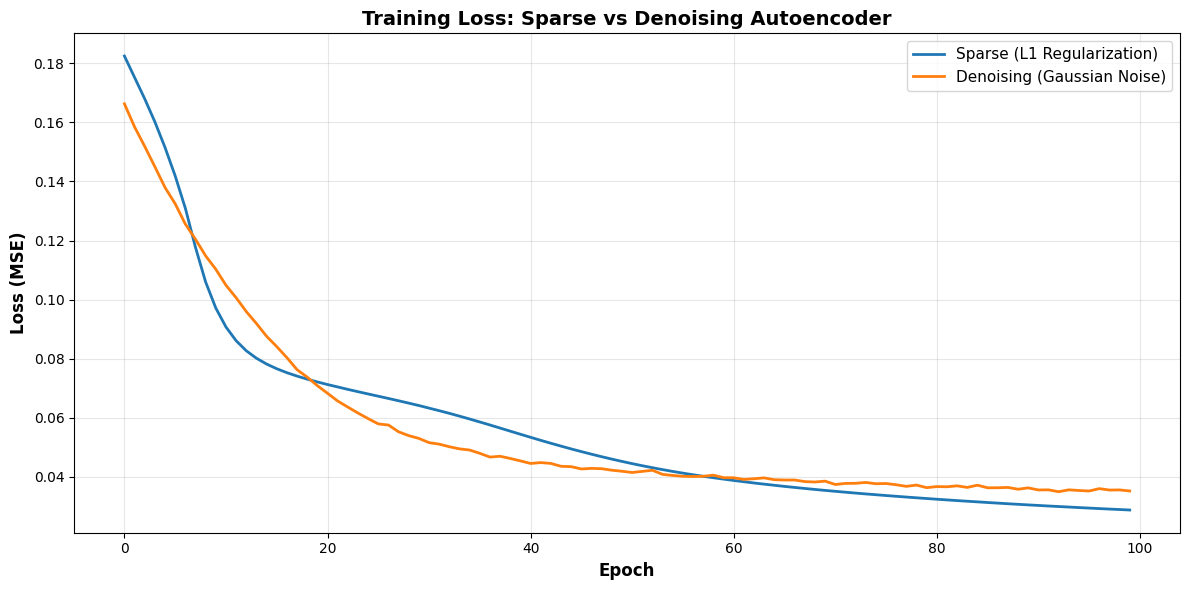

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(history_sparse.history['loss'], label='Sparse (L1 Regularization)', linewidth=2)
plt.plot(history_denoise.history['loss'], label='Denoising (Gaussian Noise)', linewidth=2)
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
plt.title('Training Loss: Sparse vs Denoising Autoencoder', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Step 8: Calculate Reconstruction Error

### Sparse Autoencoder MSE

In [13]:
decoded_sparse_data = ae_sparse.predict(X_norm, verbose=0)
mse_sparse = np.mean((X_norm - decoded_sparse_data) ** 2)
print(f"Sparse Autoencoder MSE: {mse_sparse:.6f}")

Sparse Autoencoder MSE: 0.018348


### Denoising Autoencoder MSE

In [14]:
decoded_denoise_data = ae_denoise.predict(X_norm, verbose=0)
mse_denoise = np.mean((X_norm - decoded_denoise_data) ** 2)
print(f"Denoising Autoencoder MSE: {mse_denoise:.6f}")

Denoising Autoencoder MSE: 0.029133


## Step 9: Comparison Summary

In [15]:
print("\n" + "="*70)
print("AUTOENCODER COMPARISON: SPARSE vs DENOISING")
print("="*70)
print(f"{'Type':<25} | {'Technique':<25} | {'MSE':<15}")
print("-"*70)
print(f"{'Sparse':<25} | {'L1 Regularization':<25} | {mse_sparse:<15.6f}")
print(f"{'Denoising':<25} | {'Gaussian Noise (σ=0.2)':<25} | {mse_denoise:<15.6f}")
print("="*70)

print("\nKey Differences:")
print("- Sparse: Forces many neurons to be inactive (sparse representations)")
print("- Denoising: Learns to reconstruct from corrupted input (robust features)")


AUTOENCODER COMPARISON: SPARSE vs DENOISING
Type                      | Technique                 | MSE            
----------------------------------------------------------------------
Sparse                    | L1 Regularization         | 0.018348       
Denoising                 | Gaussian Noise (σ=0.2)    | 0.029133       

Key Differences:
- Sparse: Forces many neurons to be inactive (sparse representations)
- Denoising: Learns to reconstruct from corrupted input (robust features)


## Summary

**Key Observations:**
- Sparse autoencoder uses L1 regularization on activations
- Denoising autoencoder adds Gaussian noise to input
- Both compress 7 features to 3 dimensions
- Different regularization strategies for different use cases